In [ ]:
#@title Import libraries and text data
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import sys
import random
csv.field_size_limit(sys.maxsize)
random.seed(234)

## If running on colab / google drive, will need to mount drive
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda")

Mounted at /content/drive


# Generate the Dataset - Should be done outside of colab

In [ ]:
stepsize = 0.001
thresh = 0
divstepskip = 1
s=10
p=28
b=8.0/3
def givebutt(x,y,z, r):
  x1=x
  y1=y
  z1=z
  t=0
  while t<r:
    xn = x1+stepsize*s*(y1-x1)
    yn = y1+stepsize*(x1*(p-z1)-y1)
    zn = z1+stepsize*(x1*y1-b*z1)
    x1=xn
    y1=yn
    z1=zn
    t += 1
    yield (x1,y1,z1)



In [ ]:
!pip install dill
import dill
from pdb import find_function
from types import NoneType
from sklearn.model_selection import train_test_split





X = []
y = []

# Generates the attractor
a = givebutt(0,20,1,100001)

# Collects some of the points
X = []
count = 0
for i in a:
  if count % 10 == 0:
    X.append(i)
  count += 1






X = np.array(X)
y = []



# finds how long it takes for a slight offset to cause a divergence at a certain point
shiftmin = 0.5  # minimum offset
shiftmax = 1.5  # maximum offset
trueX = []  # contains the input datapoints
wrapthresh = 100  # makes sure the offset is not the point right before or after

for i in range(len(X)):
  best = None  # best candidate for offset datapoint - closest one in the offset range
  for j in range(len(X)):
    if i != j and abs(j-i) > wrapthresh:
      if np.linalg.norm(X[i]-X[j]) <= shiftmax and np.linalg.norm(X[i]- X[j]) >= shiftmin:
        if best is None:
          best = j
        elif np.linalg.norm(X[i]-X[j]) < np.linalg.norm(X[i]-X[best]):
          best = j

  if best is not None:  # if there is a offset candidate use it to create a datapoint on how long it takes to diverge
    k = 0
    finished = False
    while i+k < len(X) and best+k < len(X):
      if (X[i+k] @ X[best+k])/(np.linalg.norm(X[i+k])*np.linalg.norm(X[best+k])) <= 0.5:
        finished = True
        break
      else:
        k += 1
    if finished:
      trueX.append(X[i])
      y.append(k/600)


X = np.array(trueX)
y = np.array(y)
print(X)
print(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)
things = [X_train, X_test, y_train, y_test]

save_path = "/content/drive/MyDrive/Chaos Folder/data.dill"
with open(save_path, "wb") as f:
  dill.dump(things, f)







[[-8.2056641  -7.31441898 31.10867886]
 [-8.10635946 -6.99763697 30.86722993]
 [-7.98741506 -6.70754429 30.60019355]
 ...
 [ 0.46722503  0.39781081 16.2030932 ]
 [ 0.46283794  0.44932394 15.77809235]
 [ 0.46384367  0.50203137 15.36451993]]
[0.97166667 0.97       0.96833333 ... 0.525      0.52333333 0.52166667]


# Load the data

In [ ]:
!pip install dill # loads data and adjusts it for the network - scales output with tanh and scales input to lie mostly in [0,1] interval
import dill
from pdb import find_function
from os import XATTR_CREATE
from types import NoneType
from sklearn.model_selection import train_test_split
save_path = "/content/drive/MyDrive/Chaos Folder/data (1).dill"
things = dill.load(open(save_path, "rb"))
for x in range(len(things)):
  things[x] = torch.Tensor(things[x]).to(device)
  if x == 0 or x == 1:
    things[x] /= 20
  else:
    things[x] = torch.reshape(torch.tanh(things[x]), (len(things[x]), 1))


X_train, X_test, y_train, y_test = things

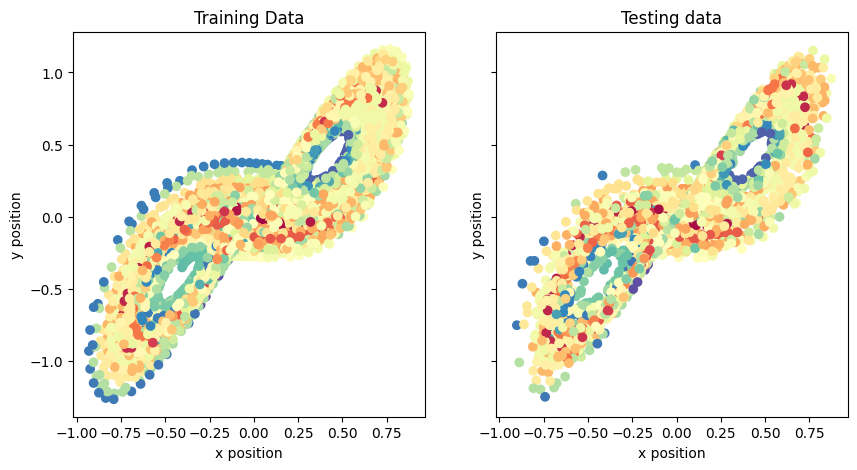

In [ ]:
# Visualize the data - warmer = shorter time to divergence
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train.cpu().numpy()[:, 0], X_train.cpu().numpy()[:, 1], c=y_train.cpu().numpy(), cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("x position")
train_ax.set_ylabel("y position")

test_ax.scatter(X_test.cpu().numpy()[:, 0], X_test.cpu().numpy()[:, 1], c=y_test.cpu().numpy(), cmap=plt.cm.Spectral)
test_ax.set_xlabel("x position")
test_ax.set_ylabel("y position")
test_ax.set_title("Testing data")
plt.show()

# Training the Network

In [ ]:
# Train Function
def train(model, x_train, y_train,
          num_epochs=5, batch_size=500, lr=0.001, report=1000, save_path = "/content/drive/MyDrive/Chaos Folder/truemodel321.dill"):



    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    t = 0

    def snapshot(loss):  # snapshot of progress
        print("Train Loss: "+str(loss))

    # stores the losses to graph them
    losslist = []

    # train loop
    for epoch in range(num_epochs):
        print("Epoch "+str(epoch))
        print()
        batchesdone = 0  # used to calcuate average loss
        totalloss = 0  # sum of the loss of each batch
        model.train()
        for batch_x, batch_y in train_loader:
            batchesdone += 1

            # basic training operations
            optimizer.zero_grad()
            scores = model(batch_x.to(torch.float))
            loss = loss_fn(scores, batch_y.to(torch.float))
            totalloss += loss.item()
            loss.backward()
            optimizer.step()

            # takes a snapshot every [report] batches
            t += 1
            if t % report == 0:
              snapshot(loss.item())

        # records the average loss
        totalloss /= batchesdone
        losslist.append(totalloss)





        print("Epoch Train Loss: "+str(totalloss))
        print()

    # saves the model
    torch.save(model, save_path, pickle_module=dill)

    # graphs the model
    import matplotlib
    plt.plot(losslist)
    plt.show()

Epoch 0

Epoch Train Loss: 0.19261219023896348

Epoch 1

Train Loss: 0.024600660428404808
Epoch Train Loss: 0.03576266447580067

Epoch 2

Epoch Train Loss: 0.028525046260364582

Epoch 3

Train Loss: 0.03756527602672577
Epoch Train Loss: 0.026633530938787904

Epoch 4

Train Loss: 0.040973491966724396
Epoch Train Loss: 0.026075994355556062

Epoch 5

Epoch Train Loss: 0.025747584244281342

Epoch 6

Train Loss: 0.008056620135903358
Epoch Train Loss: 0.02553687153920987

Epoch 7

Epoch Train Loss: 0.02529153974476344

Epoch 8

Train Loss: 0.012206658720970154
Epoch Train Loss: 0.025112227164058917

Epoch 9

Train Loss: 0.024984000250697136
Epoch Train Loss: 0.02494961303552304

Epoch 10

Epoch Train Loss: 0.02477138611898966

Epoch 11

Train Loss: 0.03149102255702019
Epoch Train Loss: 0.02460469261948589

Epoch 12

Train Loss: 0.06548554450273514
Epoch Train Loss: 0.02440787530777865

Epoch 13

Epoch Train Loss: 0.024322608666158554

Epoch 14

Train Loss: 0.01993425004184246
Epoch Train Los

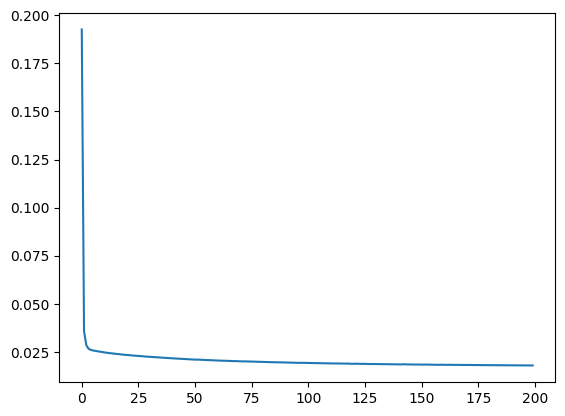

In [ ]:
# Trains model
model = nn.Sequential(
    nn.Linear(3, 400),
    nn.ReLU(),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Linear(100, 9),
    nn.ReLU(),





    nn.Linear(9, 1)
)
model.to(device).to(torch.float)
train(model, X_train, y_train, batch_size=10, num_epochs=200, lr=0.00002)

Loss: 0.01832856982946396


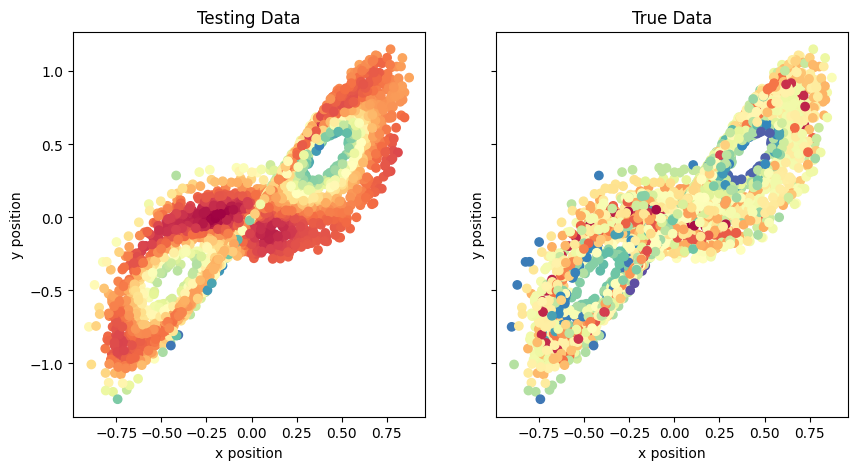

In [ ]:
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Chaos Folder/truemodel321.dill"
model = torch.load(save_path, pickle_module=dill)

# Evaluate the model
model.eval()
test_scores = None
with torch.no_grad():
  test_scores = model(X_test)
  test_loss = torch.mean((test_scores-y_test)**2).item()
  print("Loss: "+str(test_loss))

# Visualize the data.
fig, (test_ax, true_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
test_ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=test_scores.cpu().numpy(), cmap=plt.cm.Spectral)
test_ax.set_title("Testing Data")
test_ax.set_xlabel("x position")
test_ax.set_ylabel("y position")

true_ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap=plt.cm.Spectral)
true_ax.set_title("True Data")
true_ax.set_xlabel("x position")
true_ax.set_ylabel("y position")


plt.show()